 # Tutorial: DERController


 **This tutorial introduces the pandapower `DERController`**

 The `DERController` can be used to model Distributed Energy Resource (DER) capabilities for reactive power (Q) provision. The capabilities of reactive power provision may have differnent dependencies:
 + Q(P) capability: defines the reactive power capability depending on the DER active power generation
 + Q(V) capability: defines the reactive power capability depending on the voltage at the DER network connection point

 Different local control characteristics are included and can be applied via `DERController`, in particular:
 + const Q: fixed Q setpoint
 + fixed cosphi: fixed power factor
 + cosphi(P): power factor-watt function
 + Q(V): volt- var function

 Common DER capabilities and local control characteristics are predefined in DERController according to German Grid Codes.

 **First of all we import all needed packages and libraries:**

In [1]:
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd
import numpy as np

from pandapower.run import runpp
from pandapower.create import create_empty_network, create_buses, create_ext_grid, create_sgens, create_loads, create_lines, create_sgen, create_line
from pandapower.control.controller.DERController import (
    PQVArea4120V2,
    QModelConstQ,
    DERController,
    QModelCosphiPCurve,
    QModelCosphiP,
    QModelQVCurve,
    QVCurve,
    PQVAreaPOLYGON,
    PQAreaSTATCOM
)
from pandapower.control.controller.DERController.der_control_plot import plot_pq_area, plot_qv_area
from pandapower.timeseries import OutputWriter, DFData, run_timeseries

In [2]:
tex = False # this tutorial can use labels in latex style
# since this requires a latex installation which is not included in the CI, it is set to False here
if tex:
    plt.rcParams['text.usetex'] = 'true'
    plt.rcParams['text.latex.preamble'] = r'\usepackage{amssymb} \usepackage{amsmath} \usepackage{xfrac}'


 Then, we create a simple **grid example** and with identically connected sgens, but with different active power feed-in. This enables to **check multiple active power injection states**.

In [3]:
p_vals_5 = np.linspace(0, 5, 26)

def simple_test_net(p_vals):
    """Returns a net where n=len(p_vals) buses are connected to a external grid via a line of 5 km.
    At each of those buses, an sgens and a load is connected. The sgens have the same installed 
    active power but linearly increasing momentary active power injection.
    The demand of the loads is half of the momentary active power injections but distributed in the
    opposite order.
    """
    net = create_empty_network()
    create_buses(net, 1+len(p_vals), vn_kv=20)
    create_ext_grid(net, 0)
    sgen_buses = list(range(1, len(p_vals)+1))
    p_b_installed = max(p_vals)
    create_sgens(net, sgen_buses, p_mw=p_vals, sn_mva=p_b_installed)
    create_loads(net, sgen_buses, p_mw=p_vals[::-1]/2)
    create_lines(net, [0]*len(p_vals), sgen_buses, length_km=5.0, std_type="NAYY 4x50 SE")
    return net


 **And finally, we define a function that is to plot the P/Q curves and Q/Vm curves from timeseries results:**

In [4]:
def plot_function(net, der_ctrl=None, pq_area=None, qv_area=None, ow=None, saturate_sn_mva=np.nan,
                  show=True, tex=False):
    label = 'Operation points'
    # --- get pq_area and qv_area from inputs
    if pq_area is None and der_ctrl is not None:
        pq_area = getattr(getattr(der_ctrl, "pqv_area", {}), "pq_area", None)
    if qv_area is None and der_ctrl is not None:
        qv_area = getattr(getattr(der_ctrl, "pqv_area", {}), "qv_area", None)

    # --- initiate figure and axes
    n_cols = int(pq_area is not None) + int(qv_area is not None)
    if n_cols == 0:
        print("No plot made since no pq_area nor qv_area available.")
        return
    fig1, axs = plt.subplots(ncols=n_cols, figsize=(5.25*n_cols+1.5, 4.5))
    if n_cols == 2:
        (ax1, ax2) = axs
    elif pq_area is not None:
        ax1 = axs
    else:
        ax2 = axs

    # --- Plot P/Q diagram of allowed area and resulting points
    if pq_area is not None:
        S_N = net.sgen.sn_mva.at[0]
        plot_pq_area(pq_area, title=pq_area.name(), ax=ax1, saturate_sn_pu=saturate_sn_mva/S_N,
                       circle_segment=45, tex=tex)
        xs = (net.res_sgen.q_mvar if ow is None else ow.output["res_sgen.q_mvar"][0]) / S_N
        ys = (net.res_sgen.p_mw if ow is None else ow.output["res_sgen.p_mw"][0]) / S_N
        for x, y in zip(xs, ys):
            ax1.scatter(x, y, label=label, linestyle='-')
        ax1.set_ylim(0, max(np.max(ys.values), 1)+0.1)

    # --- Plot Q/V diagram of allowed area and resulting points
    if qv_area is not None:
        plot_qv_area(qv_area, title=qv_area.name(), ax=ax2, tex=tex)
        xs = net.res_bus.vm_pu.iloc[1:] if ow is None else ow.output['res_bus.vm_pu'][1]
        ys = (net.res_sgen.q_mvar if ow is None else ow.output["res_sgen.q_mvar"][0]) / S_N
        for x, y in zip(xs, ys):
            ax2.scatter(x, y, label=label)

    # --- if two parts plotted, remove legends of both parts and add a common legend
    if n_cols == 2:
        ax1.get_legend().remove()
        ax2.get_legend().remove()
        handles, labels = ax1.get_legend_handles_labels()
        if tex:
            labels = ['$Q_{min}$','$Q_{max}$','$S_{max}$',label]
        else:
            labels = ['Qmin','Qmax','Smax',label]
        fig1.legend(handles, labels, ncol=4, framealpha=0, bbox_to_anchor=[0.7, 1.05])

    plt.tight_layout()
    if show:
        plt.show()
    return axs


 ## Q(P) Capability
 The Q(P) capability defines the reactive power capability of the DERs depending on their active power generation. The Q(P) capability of the DERs are usually defined in the national Requirements for Generators (RfG) or grid codes.

 In this simple example, a Q(P) capability according to the German medium voltage RfG VDE AR-N 4120 (Variant 2) is applied. We set a fixed reactive power setpoint `q=0.5` which is outside of the Q(P)-capability. Consequently, the `DERController` is needed to set the Q provision within its limits.

 The results of the following code, which gets plotted (first look at the plot left!), show that the reactive power is usually limited to `0.41 Sn` which is a power factor of `0.925 overexceited`. If the active power gets lower than `0.2 Sn`, also the reactive power gets reduced.

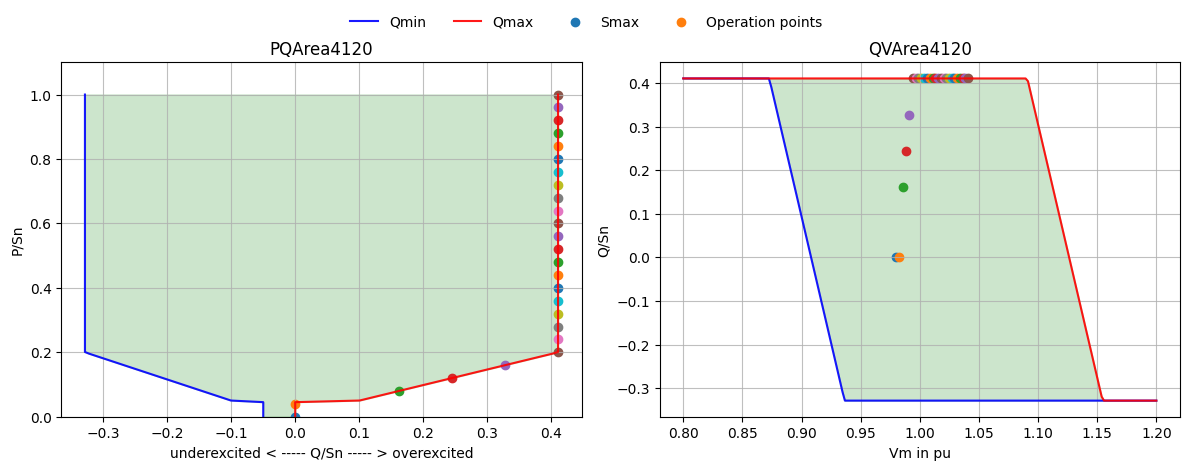

In [5]:
net = simple_test_net(p_vals_5)

# define PQV area, Q model and DERController
pqv_area = PQVArea4120V2()
q_model = QModelConstQ(q_pu=0.5)
ctrl_sgen_new = DERController(
    net, net.sgen.index, q_model=q_model, pqv_area=pqv_area)

# run power flows and plot
runpp(net, run_control=True)
axs = plot_function(net, ctrl_sgen_new, tex=tex)

 ## Inverter apparent power limitation

According to the most recent VDE AR N standards, reactive power provision must be available even for full active power injection.
To, nevertheless, enable reducing power injection depending on maximum apparent power, such value can be passed as parameter `saturate_sn_mva` (default is NaN).
If `saturate_sn_mva` is not NaN, `q_prio` defines which power is reduced to achieve the apparent power limitation. In other cases, the parameter is inactive.

+ q_prio = True (default): DER active power is curtailed
+ q_prio = False: DER reactive power is curtailed


 Let's repeat the last calculation with `saturate_sn_mva=1.02*net.sgen.p_mw.max()` and `q_prio=True` to see the difference to the last results (again focus on the left plot): Due to the active power reduction, there are no dots with `p > sqrt(saturate_sn_mva^2 - q^2)`.
 Also note that, according to `PQVArea4120V2`, the plotted green area stays limited to `p_mw <= sn_mva` (sn_mva is used as installed active power generation), independed from given `saturate_sn_mva` (dashed black line).

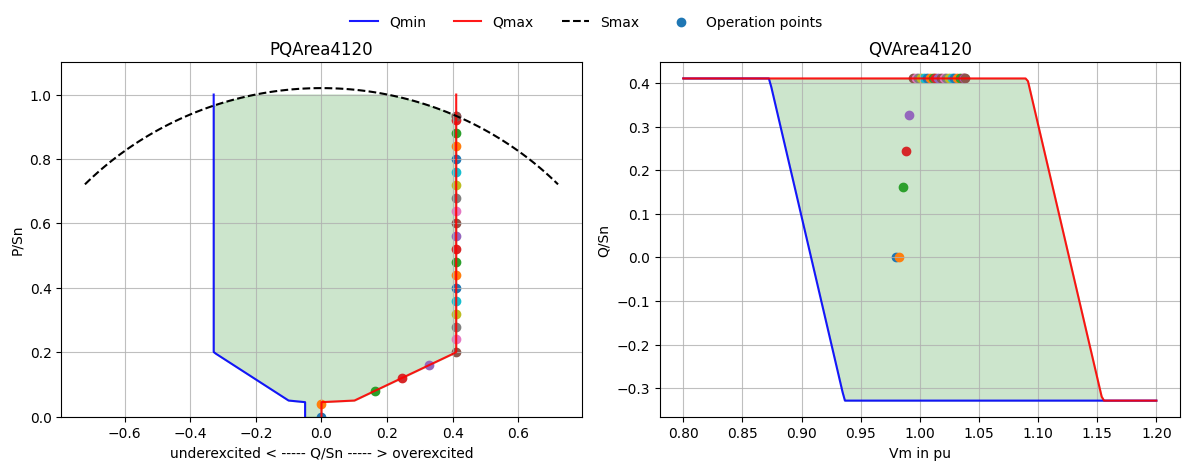

In [6]:
# change saturate_sn_mva using a new controller
net = simple_test_net(p_vals_5)
saturate_sn_mva_5 = 1.02 * net.sgen.p_mw.max()

# define PQV area, Q model and DERController
pqv_area = PQVArea4120V2()
q_model = QModelConstQ(q_pu=0.5)

ctrl_sgen_new = DERController(
    net, net.sgen.index, q_model=q_model, pqv_area=pqv_area,
    saturate_sn_mva=saturate_sn_mva_5, q_prio=True)

# run timeseries and plot results
runpp(net, run_control=True)
axs = plot_function(net, ctrl_sgen_new, saturate_sn_mva=saturate_sn_mva_5, tex=tex)


 If we consider `q_prio=False`, we can see in the left plot, that, for some operation points, q is reduced to zero to hold apparent power limits:

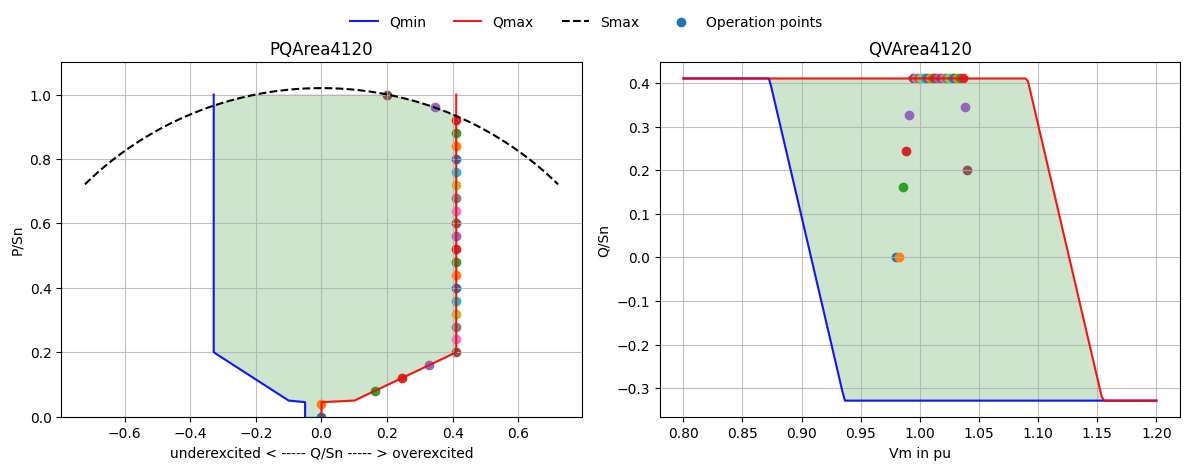

In [7]:
# change q_prio using a new controller
net = simple_test_net(p_vals_5)

# define PQV area, Q model and DERController
ctrl_sgen_new = DERController(
    net, net.sgen.index, q_model=QModelConstQ(q_pu=0.5),
    pqv_area=PQVArea4120V2(), saturate_sn_mva=saturate_sn_mva_5, q_prio=False)

# run timeseries and plot results
runpp(net, run_control=True)
axs = plot_function(net, ctrl_sgen_new, saturate_sn_mva=saturate_sn_mva_5, tex=tex)


 ## Q(V) capability and voltage limitation function

 To visualize limiting the reactive power depending on the voltage of the RES connection point, we increase plant sizes up to 16 MW. Then there is sufficient voltage rise to show that the controller reacts on over voltages via decreasing the inductive reactive power provision (overexcited behavior). That reduction is not used if the active power is low since then no overvoltages occur.

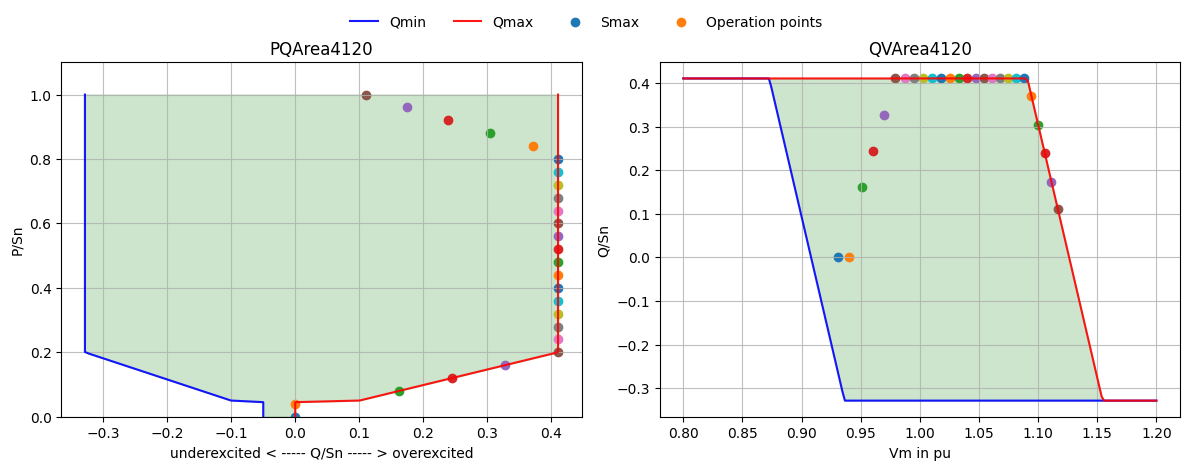

In [8]:
p_vals_16 = np.linspace(0, 16, 26)
net = simple_test_net(p_vals_16)

# define PQV area, Q model and DERController
ctrl_sgen_new = DERController(
    net, net.sgen.index, q_model=QModelConstQ(q_pu=0.5),
    pqv_area=PQVArea4120V2())

# run power flows and plot
runpp(net, run_control=True)
axs = plot_function(net, ctrl_sgen_new, tex=tex)


 To show that the PQ area, the QV area *and* the `saturate_sn_mva` parameter are considered simultaneously, we set a value to `saturate_sn_mva` that is below the highest apparent power reached:

In [9]:
s_sgen = pd.Series((net.res_sgen.p_mw**2 + net.res_sgen.q_mvar**2)**0.5, name="s_mva")
print(pd.concat([net.res_sgen, s_sgen], axis=1).iloc[-3:])

     p_mw    q_mvar      s_mva
23  14.72  3.816713  15.206765
24  15.36  2.787381  15.610865
25  16.00  1.776129  16.098280


In [10]:
assert s_sgen.max() > 16.08  # -> saturate_sn_mva=16.08 MVA will be relevant

net_saturated = deepcopy(net)
net_saturated.controller.object.iat[0].saturate_sn_mva = 16.08
runpp(net_saturated, run_control=True)

s_sgen_saturated = pd.Series((net_saturated.res_sgen.p_mw**2 + net_saturated.res_sgen.q_mvar**2)**0.5, name="s_mva")
assert np.isclose(s_sgen_saturated.max(), 16.08, atol=1e-5)
print(pd.concat([net_saturated.res_sgen, s_sgen_saturated], axis=1).iloc[-3:])

        p_mw    q_mvar      s_mva
23  14.72000  3.816718  15.206766
24  15.36000  2.787385  15.610865
25  15.97918  1.797850  16.080002


 ## Modeling reactive power characteristics
 Among a static reactive power provision, as previously used in the tutorial (`q=0.5`), there are more advanced and grid-supporting reactive power behaviors.

 ### Cosphi(P) curve
 Because active power feed-in leads to a voltage increase, an `cosphi(P)` characteristic is applied by some distributed energy resources (DERs) to counteract the voltage rise by underexcited reactive power behavior, as exemplified in the following.

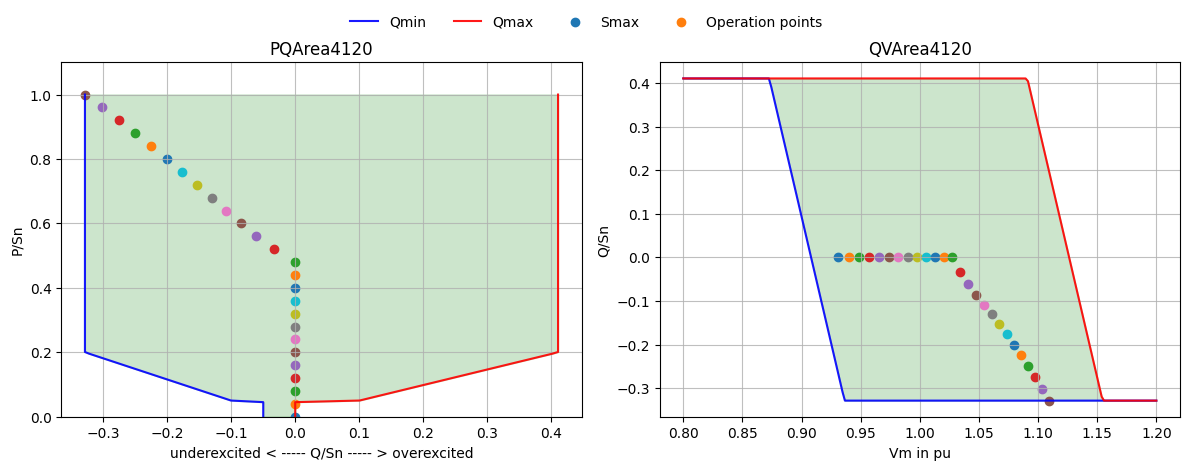

In [11]:
net_cosphiP = simple_test_net(p_vals_16)

# define PQV area, Q model and DERController
q_model=QModelCosphiPCurve(cosphi_p_curve={
        'p_points_pu':(0, 0.5, 1), 'cosphi_points':(1, 1, -0.95)})

ctrl_sgen_new = DERController(
    net_cosphiP, net_cosphiP.sgen.index, q_model=q_model, pqv_area=PQVArea4120V2())

# run power flows and plot
runpp(net_cosphiP, run_control=True)
axs = plot_function(net_cosphiP, ctrl_sgen_new, tex=tex)


In constrast to the previous fixed and overexcited reactive power provision, `cosphi(P)` reduces the voltage rise and prevents to reach the upper limit of the QV area in this example. The following code provides the resulting numbers to compare.

In [12]:
greater_0_5 = net.sgen.index[net.sgen.p_mw > 0.5]
df_compare = pd.DataFrame({
    "Vm_qfix": net.res_bus.vm_pu.loc[net.sgen.bus.loc[greater_0_5]].values,
    "Vm_cosphiP": net_cosphiP.res_bus.vm_pu.loc[net_cosphiP.sgen.bus.loc[greater_0_5]].values,
    "P_qfix": net.res_sgen.p_mw.loc[greater_0_5],
    "P_cosphiP": net_cosphiP.res_sgen.p_mw.loc[greater_0_5],
    "Q_qfix": net.res_sgen.q_mvar.loc[greater_0_5],
    "Q_cosphiP": net_cosphiP.res_sgen.q_mvar.loc[greater_0_5],
})
print(df_compare)

     Vm_qfix  Vm_cosphiP  P_qfix  P_cosphiP    Q_qfix  Q_cosphiP
1   0.939923    0.939923    0.64       0.64  0.000000   0.000000
2   0.951177    0.948604    1.28       1.28  2.594440   0.000000
3   0.960782    0.957118    1.92       1.92  3.920394   0.000000
4   0.970094    0.965476    2.56       2.56  5.246347   0.000000
5   0.979133    0.973685    3.20       3.20  6.572300   0.000000
6   0.987179    0.981753    3.84       3.84  6.572300   0.000000
7   0.995092    0.989687    4.48       4.48  6.572300   0.000000
8   1.002878    0.997493    5.12       5.12  6.572300   0.000000
9   1.010543    1.005178    5.76       5.76  6.572300   0.000000
10  1.018092    1.012747    6.40       6.40  6.572300   0.000000
11  1.025532    1.020205    7.04       7.04  6.572300   0.000000
12  1.032865    1.027556    7.68       7.68  6.572300   0.000000
13  1.040098    1.034271    8.32       8.32  6.572300  -0.526986
14  1.047233    1.040949    8.96       8.96  6.572300  -0.985946
15  1.054275    1.047611 

 ### Cosphi(P)

 In addition, a model for a fixed cosphi depending on the momentary active power is available.

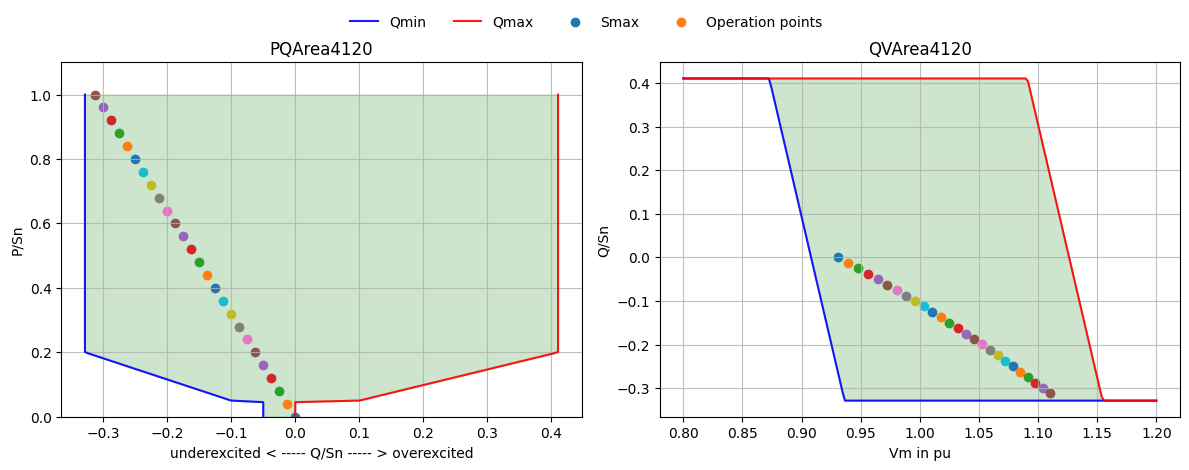

In [13]:
net = simple_test_net(p_vals_16)

# define PQV area, Q model and DERController
q_model = QModelCosphiP(cosphi=-0.95)

ctrl_sgen_new = DERController(
    net, net.sgen.index, q_model=q_model, pqv_area=PQVArea4120V2())

# run power flows and plot
runpp(net, run_control=True)
axs = plot_function(net, ctrl_sgen_new, tex=tex)


 ### Q(V) curve
 A widespread reactive power behavior in recent DERs is applying a Q(V) characteristic. The curve of the Q(V) characteristic can be freely customizable. The exemplary curve, that is applied in the following example, is plotted in the QV area by a grey line. The reactive power reduction in cases of very low active power injections causes deviations to that custom Q(V) curve.

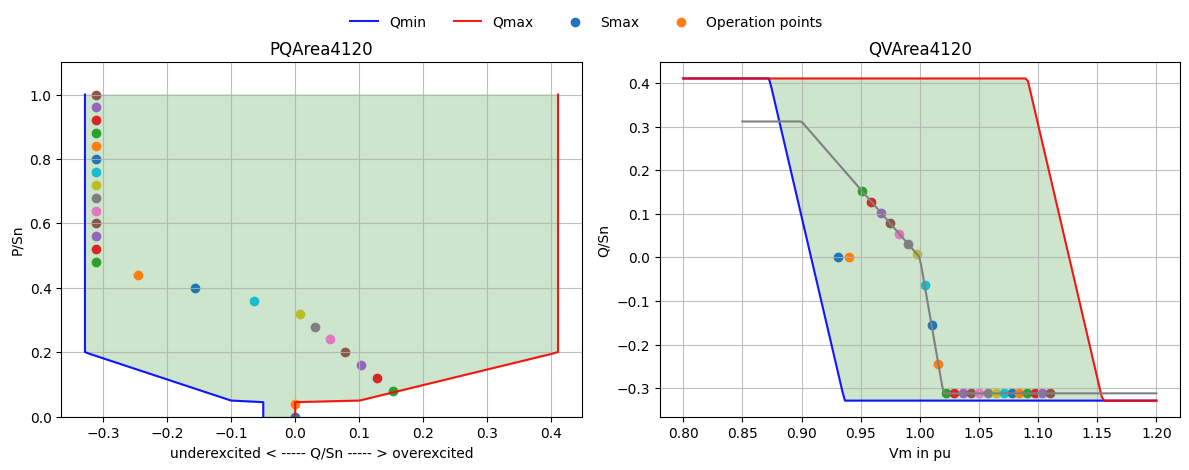

In [14]:
net = simple_test_net(p_vals_16)

# define PQV area, Q model and DERController
q_model = QModelQVCurve(qv_curve=QVCurve(
    vm_points_pu=(0, 0.90, 1.00, 1.02, 2),
    q_points_pu=(0.312, 0.312, 0, -0.312, -0.312)))

ctrl_sgen_new = DERController(
    net, net.sgen.index, q_model=q_model, pqv_area=PQVArea4120V2())

# run power flows and plot
runpp(net, run_control=True)
axs = plot_function(net, ctrl_sgen_new, show=False, tex=tex)

# plot theoretical QVCurve
vm_curve = np.linspace(0.85, 1.20, 200)
q_curve = np.interp(vm_curve, q_model.qv_curve.vm_points_pu, q_model.qv_curve.q_points_pu)
axs[1].plot(vm_curve, q_curve, color="grey")
plt.show()

## PQ and QV Areas
So far, 'PQVArea4120V2' has been used as an example. Such PQV areas are available for all voltage levels
* EHV (380 kV and 220 kV): PQVArea4130
* HV (110 kV): PQVArea4120
* MV (e.g. 10 kV or 20 kV): PQVArea4110
* LV (e.g. 0.4 kV): PQVArea4105
and also in the different variants if standardized.

### Polygonal PQV area
Any piecewise linear areas can be defined and used with the help of `PQVAreaPOLYGON`. The following code box provides an example.

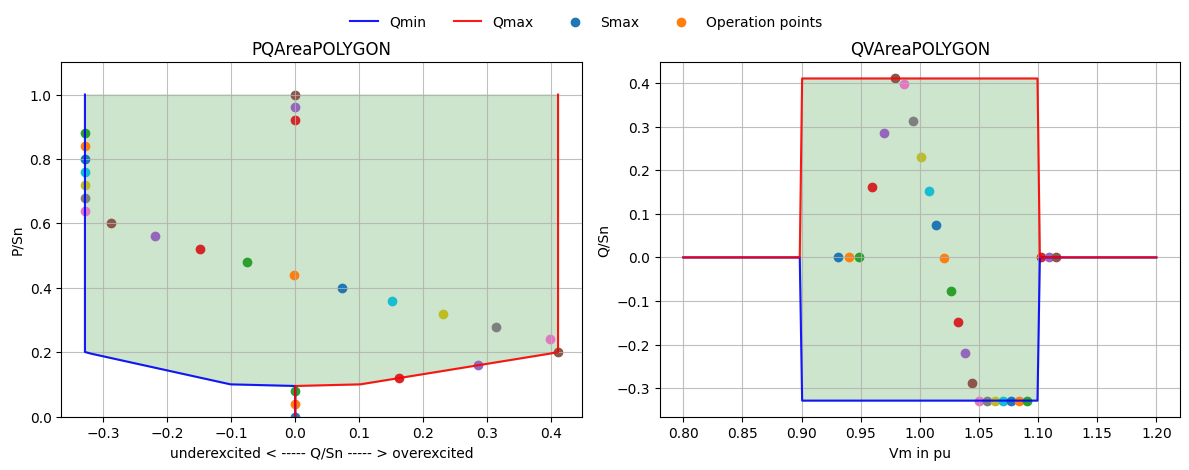

In [15]:
net = simple_test_net(p_vals_16)

# define PQV area, Q model and DERController
q_model=QModelQVCurve({
        "vm_points_pu": (0, 0.98, 1.06),
        "q_points_pu": (0.484, 0.484, -0.484)})

p_points_pu = (0.1, 0.2, 1, 1, 0.2, 0.1, 0.1)
q_pq_points_pu = (0.1, 0.410775, 0.410775, -0.328684, -0.328684, -0.1, 0.1)
q_qv_points_pu = (0.410775, 0.410775, -0.328684, -0.328684, 0.410775)
vm_points_pu = (1.1, 0.9, 0.9, 1.1, 1.1)
pqv_area = PQVAreaPOLYGON(p_points_pu, q_pq_points_pu, q_qv_points_pu, vm_points_pu)

ctrl_sgen_new = DERController(
    net, net.sgen.index, q_model=q_model, pqv_area=pqv_area)
    
# run power flows and plot
runpp(net, run_control=True)
axs = plot_function(net, ctrl_sgen_new, tex=tex)

Multiple active power injection states can also be analyzed performing a timeseries calculation of one controller sgen. This is applied in the following for demonstration reasons. Furthermore, negative active power values are assumed in the timeseries data to show the functionality of profile_sacle.

In [16]:
def simple_test_net_for_timeseries():
    # this is basically the same grid as simple_test_net() but with only one line to one bus
    # with one sgen
    net = create_empty_network()
    create_buses(net, 2, vn_kv=20)
    create_ext_grid(net, 0)
    create_sgen(net, 1, p_mw=5., sn_mva=5.)
    create_line(net, 0, 1, length_km=5.0, std_type="NAYY 4x50 SE")

    # create outputwriter and define variables to log
    ow = OutputWriter(net)
    ow.log_variable("res_sgen", "p_mw")
    ow.log_variable("res_sgen", "q_mvar")

    return net, ow

ts_data = pd.DataFrame({"p_0": -p_vals_5})
data = DFData(ts_data)

### Statcom capability
Statcom capability does not depend on active power p as the previous where the flexibility is reduced in low injection cases.
`min_q` and `max_q` are reactive power limits that are adjustable and user defined parameters.
A limitation corresponding to `saturate_sn_mva` is possible with this PQ area, as shown above.

If only one of both flexibility areas, PQ area or QV area, should be considered, this area can be passed as `pqv_area` directly to the DERController.
This is illustrated in the following example, as well.

100%|██████████| 26/26 [00:01<00:00, 20.86it/s]


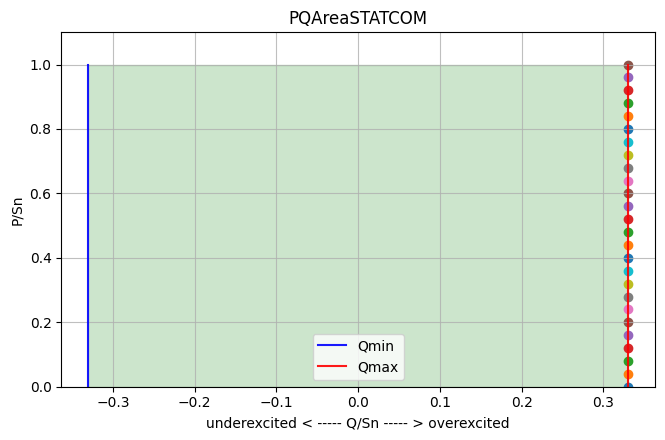

In [17]:
net, ow = simple_test_net_for_timeseries()

# define PQV area, Q model and DERController
pq_area = PQAreaSTATCOM(min_q_pu=-0.33, max_q_pu=0.33)

ctrl_sgen_new = DERController(
    net, 0, q_model=QModelConstQ(q_pu=0.5),
    pqv_area=pq_area,
    data_source=data, p_profile="p_0", profile_scale=-1)

# run power flows and plot
run_timeseries(net, time_steps=range(len(p_vals_5)))
axs = plot_function(net, pq_area=pq_area, ow=ow, tex=tex)
